# Testing Fidelity With Trained Model
The purpose of this notebook is to experiment with the model trained in [this notebook](training_new_model.ipynb). Specifically, I will be performing the rough test described in **Entry 1** of [this journal page](../Journal/10_10_24.md).

In [1]:
### IMPORTS
import warnings
import os
from lambeq import BobcatParser, RemoveCupsRewriter, AtomicType, IQPAnsatz, TketModel
import numpy as np
from pytket.extensions.qiskit import AerBackend

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

c:\Users\Luke\anaconda3\envs\QNLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we configure the backend and initialize a `TketModel` object and load the model from the file saved last time.

In [2]:
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 1024
}

model = TketModel.from_checkpoint("model.lt", backend_config=backend_config)

We test the model has been loaded properly by parsing it a sentence from the training set, and ensuring the output is as expected.

In [3]:

# Read Training Data
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])  # Either 0 or 1 depending on whether about food or IT
            labels.append([t, 1-t])  # Converting to 2D array
            sentences.append(line[1:].strip())
    return labels, sentences

train_labels, train_data = read_data('data/training_data.txt')

# Convert to diagram
index = 39
parser = BobcatParser()
remove_cups = RemoveCupsRewriter()
train_diagram = remove_cups(parser.sentence2diagram(train_data[index]))
# Convert to QC
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1, n_single_qubit_params=3)
train_circuit = [ansatz(train_diagram)]
# Parse to model + compare result with expected
outcome = model(train_circuit)
print(f"Expected outcome: {train_labels[index]}\nActual Outcome: {outcome[0]}")

Expected outcome: [0, 1]
Actual Outcome: [0. 1.]


We can see that the model has loaded correctly. Next we test the fidelity of a few select sentences.

In [94]:
sentence = "woman prepares sauce ."
sentence_mod = "woman prepares tasty sauce ."

sentence_diagram = remove_cups(parser.sentence2diagram(sentence))
sentence_mod_diagram = remove_cups(parser.sentence2diagram(sentence_mod))
sentence_circuit = ansatz(sentence_diagram)

sentence_mod_circuit = ansatz(sentence_mod_diagram)
sentence_state, sentence_mod_state = model([sentence_circuit, sentence_mod_circuit])  # Retrieve state vectors

sentence_state = sentence_state/np.linalg.norm(sentence_state)  # Normalize
sentence_mod_state = sentence_mod_state/np.linalg.norm(sentence_mod_state)  # Normalize


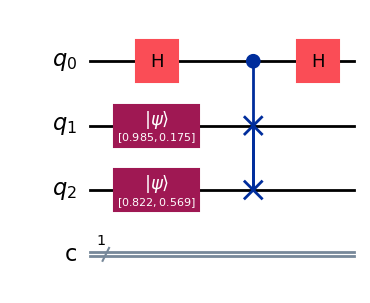

In [95]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3, 1)
qc.initialize(sentence_state, 1)
qc.initialize(sentence_mod_state, 2)
qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.draw('mpl')

In [98]:
from qiskit_aer import AerSimulator

qc.measure(0, 0)
sim = AerSimulator()
job = sim.run(qc)
results = job.result()
counts = results.get_counts()
if '0' and '1' in counts.keys():
    fidelity = counts['0']/1000 - counts['1']/1000
    print(f'Fidelity: {fidelity}')
else:
    print(f'Fidelity: 1')

Fidelity: 0.8380000000000001


Now we test with two completely different sentences.

In [99]:
sentence = "woman prepares sauce ."
sentence_mod = "skillful person prepares software ."

sentence_diagram = remove_cups(parser.sentence2diagram(sentence))
sentence_mod_diagram = remove_cups(parser.sentence2diagram(sentence_mod))
sentence_circuit = ansatz(sentence_diagram)

sentence_mod_circuit = ansatz(sentence_mod_diagram)
sentence_state, sentence_mod_state = model([sentence_circuit, sentence_mod_circuit])  # Retrieve state vectors

sentence_state = sentence_state/np.linalg.norm(sentence_state)  # Normalize
sentence_mod_state = sentence_mod_state/np.linalg.norm(sentence_mod_state)  # Normalize

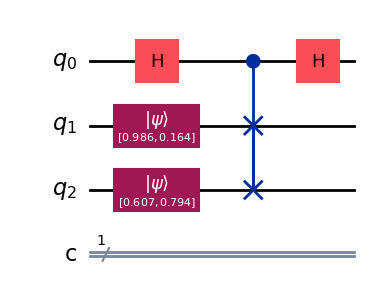

In [100]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3, 1)
qc.initialize(sentence_state, 1)
qc.initialize(sentence_mod_state, 2)
qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.draw('mpl')

In [103]:
qc.measure(0, 0)
sim = AerSimulator()
job = sim.run(qc)
results = job.result()
counts = results.get_counts()
if '0' and '1' in counts.keys():
    fidelity = counts['0']/1000 - counts['1']/1000
    print(f'Fidelity: {fidelity}')
else:
    print(f'Fidelity: 1')

Fidelity: 0.536


The results are very changeable - this is because the state output from the model changes. We will create a function and run it 1024 times to get average qubit states for the two sentences, and then use these averaged states for state fidelity calculation.

In [104]:
def sentence_to_state(sentence1, sentence2, shots=25):
    sentence1_states = []
    sentence2_states = []
    for i in range(shots):
        sentence1_diagram = remove_cups(parser.sentence2diagram(sentence1))
        sentence2_diagram = remove_cups(parser.sentence2diagram(sentence2))
        sentence1_circuit = ansatz(sentence1_diagram)
        sentence2_circuit = ansatz(sentence2_diagram)
        sentence1_state, sentence2_state = model([sentence1_circuit, sentence2_circuit])  # Retrieve state vectors
        sentence1_states.append(sentence1_state)
        sentence2_states.append(sentence2_state)
    sentence1_avg = np.mean(sentence1_states, axis=0)
    sentence2_avg = np.mean(sentence2_states, axis=0)
    sentence1_norm = sentence1_avg/np.linalg.norm(sentence1_avg)
    sentence2_norm = sentence2_avg/np.linalg.norm(sentence2_avg)
    return(sentence1_norm, sentence2_norm)

#### Similar Sentences

In [106]:
state1, state2 = sentence_to_state("woman prepares sauce .", "woman prepares tasty sauce .")
qc = QuantumCircuit(3, 1)
qc.initialize(state1, 1)
qc.initialize(state2, 2)
qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.measure(0, 0)
sim = AerSimulator()
job = sim.run(qc, shots=1024)
results = job.result()
counts = results.get_counts()
if '0' and '1' in counts.keys():
    fidelity = counts['0']/1024 - counts['1']/1024
    print(f'Fidelity: {fidelity}')
else:
    print(f'Fidelity: 1')

Fidelity: 0.82421875


#### Different Sentences

In [107]:
state1, state2 = sentence_to_state("woman prepares sauce .", "skillful person prepares software .")
qc = QuantumCircuit(3, 1)
qc.initialize(state1, 1)
qc.initialize(state2, 2)
qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.measure(0, 0)
sim = AerSimulator()
job = sim.run(qc, shots=1024)
results = job.result()
counts = results.get_counts()
if '0' and '1' in counts.keys():
    fidelity = counts['0']/1024 - counts['1']/1024
    print(f'Fidelity: {fidelity}')
else:
    print(f'Fidelity: 1')

Fidelity: 0.619140625


#### Similar Sentences (Different Topic)

In [108]:
state1, state2 = sentence_to_state("skillful man prepares software .", "skillful person prepares software .")
qc = QuantumCircuit(3, 1)
qc.initialize(state1, 1)
qc.initialize(state2, 2)
qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.measure(0, 0)
sim = AerSimulator()
job = sim.run(qc, shots=1024)
results = job.result()
counts = results.get_counts()
if '0' and '1' in counts.keys():
    fidelity = counts['0']/1024 - counts['1']/1024
    print(f'Fidelity: {fidelity}')
else:
    print(f'Fidelity: 1')

Fidelity: 0.943359375
